In [1]:
import numpy as np 
from scipy.special import rel_entr
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns 


Declaremos una distribución y verifiquemos que la distribución es lo que esperamos 

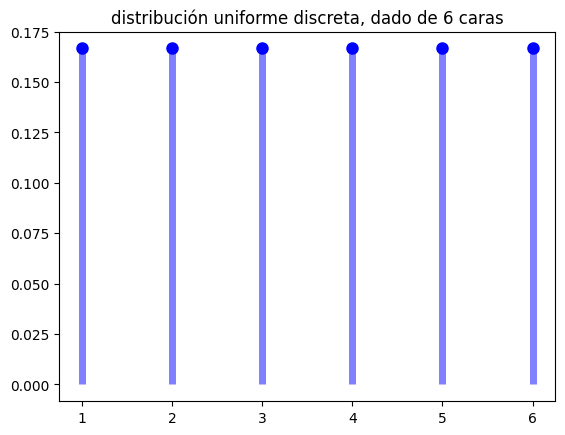

In [2]:
low, high = 1, 7

fig, ax = plt.subplots(1, 1)
x = np.arange(stats.randint.ppf(0.01, low, high+1),
              stats.randint.ppf(0.99, low, high+1))

ax.plot(x, stats.randint.pmf(x, low, high), 'bo', ms=8, label='randint pmf')
ax.vlines(x, 0, stats.randint.pmf(x, low, high), colors='b', lw=5, alpha=0.5)
plt.title("distribución uniforme discreta, dado de %d caras"%(high-low))
plt.show()

A continuación declaramos 3 funciones:
 - rel_freq: calcula la frecuencia relativa de una muestra, el vector devuelto tiene tantos o menos elementos como caras el dado, no hay frecuencias nulas 
 - experimento_muestral: la versión original, calcula el promedio de las frecuencias en un size-nuestreo 
 - every_freq: Similar a rel_freq, entregas las frecuencias relativas, pero en el orden, si una frecuencia es 0, es porque no se visitó ese estado/cara del dado

In [3]:

def rel_freq(sample, values=False):
    '''Funcion que devuelve la frecuancia relativa de los elementos de sample '''
    sample= np.asanyarray(sample)   
    freqs = [(value, np.count_nonzero(sample==value) / len(sample)) for value in set(sample)] 
    
    if values: 
        return freqs
    else: 
        return np.array(freqs)[:,1]
    

def experimento_muestras(low, high, size=15, random_state=42):
    '''
    Función aleatoria que devuelve el promedio aritmético de las frecuencias 
    a partir de una muestra de tamaño _size_ simuladas *una vez*.
    El resultado es distinto cada vez que llamamos a la función, salvo que se le 
    entregue un random_state
    
    '''
    sample = stats.randint.rvs(low, high, size=size, random_state=random_state)
    
    freqs= rel_freq(sample, values=False)
    
    return np.mean(freqs) #ignore


def every_freq(low, high, size=15, random_state=42):
    '''La función toma un vector que podría, potencialmente ser más corto y lo inserta en una más largo
    (de largo el numero de enteros en al distro uniforme), de tal manera de que los elementos faltantes tengan frecuancia
    distinta de 0
    '''
    sample = stats.randint.rvs(low, high, size=size, random_state=random_state)
    freqs = rel_freq(sample, values=True)
        
    l = sorted((freqs, np.zeros(high-low)), key=len)
    
    c = l[1].copy()
    
    for i in freqs:
        c[i[0]-1] += i[1]
    
    return np.array(c)   


Ahora usemos  un array (randomState) con semillas aleatorias para asegurarnos que no estamos repitiendo el ejercicios futilmente

- n_sims= convierte las iteraciones (iter) en una matriz de *iter x (high-low)* con las frecuencias relativas de cada una de las iteraciones de tirar el dado _sample_size_ veces.

- La función _stat.entropy(*a*,*b*)_ al igual que _rel_entr(*a*,*b*)_, entregan la entropía relativa entre distribuciones *a* y *b*, en ambos casos es necesario que *a* y *b* tengan elmismo largo (el uso de esta función, está comentada, por lo tanto no usada)

In [4]:
iter, sample_size= 1120, 50

randomState= list(set(stats.randint.rvs(0, 5000, size=iter, random_state=42)))

iter= len(randomState)

# [sum(stat.entropy(every_freq(low, high, size=25, random_state=i), unif)) for i in randomState]
n_sims=np.stack([every_freq(low, high, size=sample_size, random_state=i) for i in randomState])

print("(%d iteraciones, lanzar el dado %d veces, %d estados/caras)="%(iter, sample_size ,(high-low)), n_sims.shape)

(999 iteraciones, lanzar el dado 50 veces, 6 estados/caras)= (999, 6)


n_sim es un array de 2 dimensiones, donde el número de filas es igual al número de iteraciones, las columnas el número de caras del dado, y en cada posición [i,j] tiene la frecuencia relativa, producto dela simulación. Un valore $[i_0, j_0]=0$ quiere decir que esa cara del dado no fue visitada.

Ahora, vale la pena preguntarnos, en las columna ¿ como distribuyen los datos? Beta cada columna, Dirichlet entre todas ellas. ¿Cómo distribuyen las filas? las filas deberían tender a ser uniformes en la medida que aumentamos *sample_size*. 

Para pocas caras, hagamos la gráfica

c:\Users\rodri\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\rodri\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\rodri\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


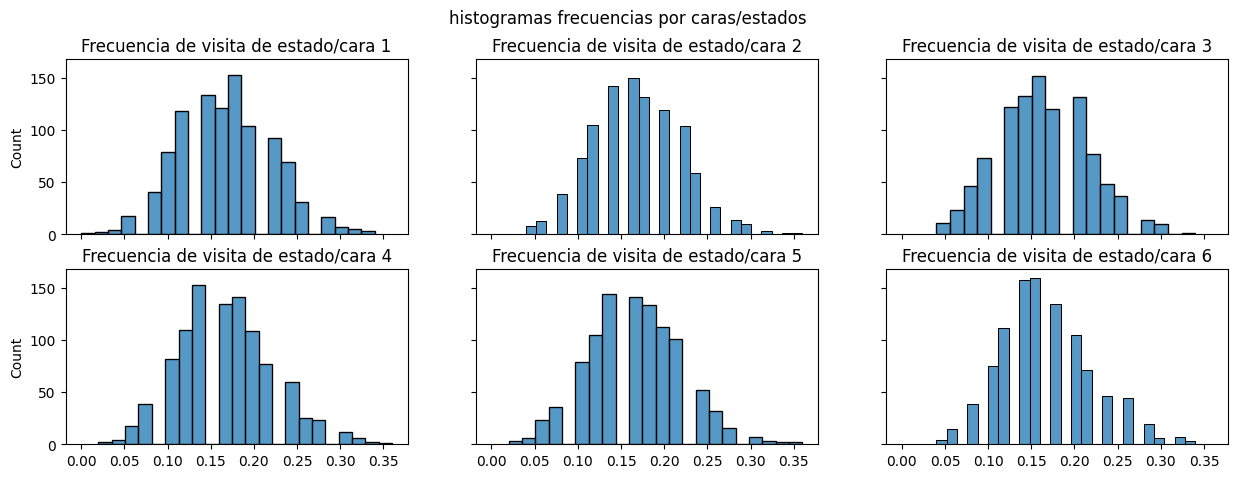

Promedio de cada estado=  [0.16758759 0.16810811 0.16388388 0.16700701 0.16662663 0.16678679]


In [5]:
fig, axes = plt.subplots(2, (high-low)//2, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle('histogramas frecuencias por caras/estados')

for i in range((high-low)):
    [alpha, beta, _, _ ] = stats.beta.fit(n_sims[:,i]) 
        
    if i<(high-low)//2:
        hist=sns.histplot(data=n_sims[:,i], ax=axes[0,i])
        
    else:
        hist=sns.histplot(data=n_sims[:,i], ax=axes[1,(i-(high-low)//2)])
    #hist.set(title="alpha= %.2f, beta= %.2f"% (alpha, beta))
    hist.set(title="Frecuencia de visita de estado/cara %d"%(i+1))
    
plt.show()    
print("Promedio de cada estado= ", np.mean(n_sims, axis =0)) 


Si quisieramos usar la maquinaria para distribuciones normales, necesitamos promedios $\bar{X}$, ya que sabemos que $\bar{X}\sim N(\mu,\sigma^2)$.
*Idea: sacar los promedios para cada columna de n_sims y trabajar ahí*

### Verifiquemos que nuestro "dado" es justo, lo haremos haciendo uso de la prueba $\chi^2$. 

Para esto, calculemos, la cantidad esperada de veces que cada cara/estado debería haber salido para un dado justo, es decir, el número total de lanzamientos dividido por el número de lados. Llamemos a este número $n_{exp}$. Por ejemplo, para N=50 tiradas de un d6, $ n_{exp}= \frac{50}{6}=8.333$

Ahora, para cada lado k (de 1 a 6, para un d6), calculemos la proporción entre,  por un lado, la diferencia del recuento experimental de veces que visitamos cada estado y el esperado $n_{exp}$, elévado al cuadrado, el esperado por el otro.

$$\chi^2_k=\frac{(n_k−n_{exp})^2}{n_{exp}}$$

para cada número posible k del dado (es decir, de k=1 a k=6, para un d6) y finalmente sumemos $\sum_{k=1}^N \chi^2_k= \chi^2$

Creemos una tabla $\chi^2$ para los grados de libertad "número de estados/caras"-1

In [6]:
from scipy.stats import chi2

p=  np.array([0.10, 0.05, 0.025, 0.01, 0.005]) #valores p 
df = (high-low)-1 #grados de libertad

table = chi2.isf(p, df)

print("Chi^2 table with %d degrees of fredom"%(df))
np.set_printoptions(suppress=True) #suprime la notación exponencial en la tabla 
np.round(np.array(list(zip(p,table))),3).T

Chi^2 table with 5 degrees of fredom


array([[ 0.1  ,  0.05 ,  0.025,  0.01 ,  0.005],
       [ 9.236, 11.07 , 12.833, 15.086, 16.75 ]])

para asegurarnos que hemos sumado bien, deberíamos tener tantas sumas como iteraciones i.e. 999=999


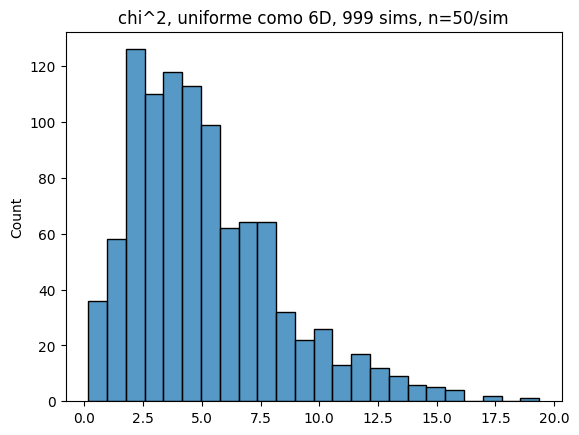

In [7]:
n_exp= sample_size/(high-low)
chi_k= ((n_sims*sample_size-n_exp)**2)/n_exp
Chi_Sumed=np.sum(chi_k, axis=1)
print("para asegurarnos que hemos sumado bien, deberíamos tener tantas sumas como iteraciones i.e. %d=%d"%(iter, Chi_Sumed.shape[0]))
sns.histplot(Chi_Sumed).set(title="chi^2, uniforme como %dD, %d sims, n=%d/sim"%((high-low),iter, sample_size))
plt.show()


Podríamos contar qué porporción de las simulaciones cumple con la tabla $\chi^2$, en la siguiente tabla:
- La primera línea nos dice lo esperado (e.g un $90\%$ de las simulaciones deberían cumplir con $\chi^2$ menor que 9.236, el $95\%$ deberían cumplir con $\chi^2$ menor que 11.07  )
- La segunda fila nos dice que porcentaje de nuestras simulaciones lo cumple la condición.

In [8]:
conteo_chi= np.array([np.count_nonzero(Chi_Sumed<=x_n)/iter for x_n in table])

print("Chi^2 results with %d degrees of fredom"%((high-low)-1))
np.set_printoptions(suppress=True) #suprime la notación exponencial en la tabla 
np.round(np.array(list(zip(1-p,conteo_chi))),3).T


Chi^2 results with 5 degrees of fredom


array([[0.9  , 0.95 , 0.975, 0.99 , 0.995],
       [0.893, 0.939, 0.969, 0.992, 0.997]])

Podríamos contar los estados no visitados por cada iteración (¿$\sim Geo$, $\sim Bin$, $\sim neg\_Bin$?) y preguntarnos para qué *sample_size* tenemos un 95% de las simulaciones con 0 frecencias nulas 

de 999 simulaciones, sólo 1 tienen al menos estados sin visitar


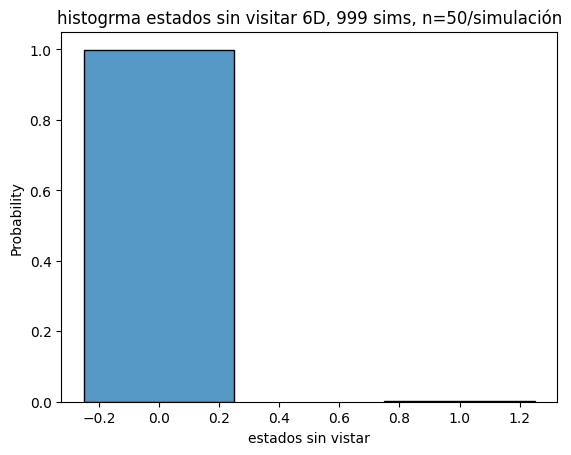

In [9]:
conteo= np.count_nonzero(n_sims<(1/sample_size), axis=1)
hist=sns.histplot(conteo, bins= [1,2,3,4], stat= "probability", discrete=True, shrink=0.5)
hist.set(xlabel="estados sin vistar", title="histogrma estados sin visitar %dD, %d sims, n=%d/simulación"%((high-low),iter, sample_size))
print("de %d simulaciones, sólo %d tienen al menos estados sin visitar"%(iter, conteo.sum()))

Hagamos ahora un barrido que nos permita saber, dado el limite superior de nuestro sistema/dado (_i.e._ la cantidad de caras del dado, o estados a visitar), qué numero de muestras nos permita decir que el 99% de las simulacioness tiene 0 estados sin visitados.

In [160]:
from tqdm.notebook import tqdm
import pandas as pd 

df = pd.DataFrame(columns = ['UpperLimit', 'SampleSize', 'Freq'])
upper_bound=np.arange(7,363,5)
sample_size= 30
TOL=0.99

for H in tqdm(upper_bound):
# for H in upper_bound:
    low, high = 1, H
    freq=0.00
    tmp=pd.Series(index= ['UpperLimit', 'SampleSize', 'Freq'], dtype='float64')
    tmp.UpperLimit= H
        
    while freq < TOL:
        n_sims=np.stack([every_freq(low, high, size=sample_size, random_state=i) for i in randomState]) # 999 iteraciones, 999 semillas diferentes, todas las frecuancias incluidos los 0
        conteo= np.count_nonzero(n_sims<(1/sample_size), axis=1) # len(conteo)=999, cuenta cuantos estados/caras de entre los H tiene frecuencia relativa menor que 1/sample_size
        freq= rel_freq(conteo, values=False)[0] # de los 999 elementos de conteo, ¿cual es la frecuencia del 0? i.e. ¿qué porcentaje de conteo tiene cero estados sin visitar?
        if freq < TOL:
            sample_size += 2
        
        
    # tmp['SampleSize', 'Freq']=[sample_size, freq]
    tmp['SampleSize']=sample_size
    tmp['Freq']= freq
    # print('caras , SampleSize & Freq = ', [H, sample_size, np.round(freq,4)])
    df=pd.concat([df.T, tmp], axis=1).T

df.reset_index(drop=True, inplace=True)
    

  0%|          | 0/72 [00:00<?, ?it/s]

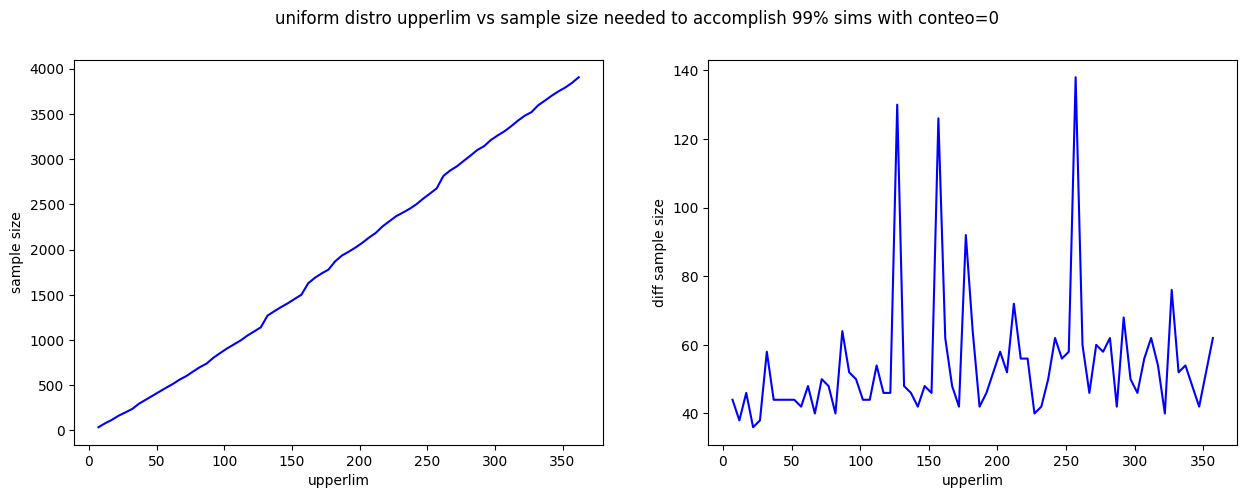

    UpperLimit  SampleSize      Freq
0          7.0        36.0  0.992993
1         12.0        80.0  0.991992
2         17.0       118.0  0.990991
3         22.0       164.0  0.991992
4         27.0       200.0  0.992993
..         ...         ...       ...
67       342.0      3700.0  0.990991
68       347.0      3748.0  0.990991
69       352.0      3790.0  0.990991
70       357.0      3842.0  0.990991
71       362.0      3904.0  0.990991

[72 rows x 3 columns]


In [162]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('uniform distro upperlim vs sample size needed to accomplish 99% sims with conteo=0')

axes[0].plot(df.UpperLimit, df.SampleSize, 'b-')
axes[0].set_xlabel("upperlim")
axes[0].set_ylabel("sample size")

axes[1].plot(df.UpperLimit[:-1],np.diff(df.SampleSize), 'b-')
axes[1].set_xlabel("upperlim")
axes[1].set_ylabel("diff sample size")

plt.show()
print(df)

para cada punto de upperlim, vamos a hacer 5 replicas, para esto, preparemos las semillas

In [14]:
metaseeds={}
while len(metaseeds)<5:
    #vamos a elegir 5 números enteros entre 0 y 100(estp puede ser cambiado) como semillas de mi semillas estocasticas 
    metaseeds=set(stats.randint.rvs(low=0, high=100, size=5)) #Voy a elegir 5 numeros al azar, estos serán las semillas de mi proxima iteración,
    if 42 in metaseeds:
        metaseeds.remove(42) # el 42 está prohíbido porque fue la semilla que usamos previamente.

lseeds=[1] #lseeds es por len(seeds)
iter= 1120 #numero inicial de iteraciones, cuando set elimine las repeticiones, queremos que sean mayor que 999
while any(np.array(lseeds)<999):
    #vamos a elegis números enteros entre 0 y 5000, estp último puede ser cambiado 
    seeds= [list(set(stats.randint.rvs(0, 5000, size=iter, random_state=ms))) for ms in metaseeds] # usamos set para garantizar que no existan elementos repetidos
    lseeds= [len(s) for s in seeds] # cuanto mide cada uno? queremos que sean más de mil iteraciones.
    iter+=2



Ahora deberíamos tener, al menos 5 mil semillas aleatorias para poder repetir el experimento 

In [143]:
DF = df 
upper_bound=np.arange(7,363,5)
TOL=0.99

for i in tqdm(np.arange(len(seeds))+1):
    tmp=pd.Series(index= ['UpperLimit', 'SampleSize'+str(i), 'Freq'+str(i)], dtype='float64')
    df = pd.DataFrame(columns = ['UpperLimit', 'SampleSize'+str(i), 'Freq'+str(i)], dtype='float64')
    sample_size= 30        
    for H in tqdm(upper_bound):
    # for H in upper_bound:
        low, high = 1, H
        freq=0.00
        tmp.UpperLimit= H
                
        while freq < TOL:
            n_sims=np.stack([every_freq(low, high, size=sample_size, random_state=s) for s in seeds[i-1]]) # 999 iteraciones, 999 semillas diferentes, todas las frecuancias incluidos los 0
            conteo= np.count_nonzero(n_sims<(1/sample_size), axis=1) # len(conteo)=999, cuenta cuantos estados/caras de entre los H tiene frecuencia relativa menor que 1/sample_size
            freq= rel_freq(conteo, values=False)[0] # de los 999 elementos de conteo, ¿cual es la frecuencia del 0? i.e. ¿qué porcentaje de conteo tiene cero estados sin visitar?
            if freq < TOL:
                sample_size += 2
              
        tmp['SampleSize'+str(i) ]=sample_size
        tmp['Freq'+str(i)]= freq
        
        df=pd.concat([df.T, tmp], axis=1).T
    df.reset_index(drop=True, inplace=True)
    DF=pd.merge(left=DF, right= df)
    
df_fin= DF.rename(columns={'SampleSize':'SampleSize0', 'Freq':'Freq0'})

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

In [174]:
df_fin= pd.merge(left=df, right=DF)
df_fin= df_fin.rename(columns={'SampleSize':'SampleSize0', 'Freq':'Freq0'})

In [176]:
from sklearn.linear_model import LinearRegression

y = pd.concat([df_fin['SampleSize0'], DF['SampleSize1'], DF['SampleSize2'], DF['SampleSize3'], DF['SampleSize4'], DF['SampleSize5']])
X = pd.concat([DF['UpperLimit'], DF['UpperLimit'], DF['UpperLimit'], DF['UpperLimit'], DF['UpperLimit'], DF['UpperLimit']])

model = LinearRegression()

# fit the model to the data
model.fit(X.values.reshape(-1, 1), y.values.reshape(-1, 1))

# print the coefficients of the linear regression
print(f'slope: {model.coef_[0][0]}, intercept: {model.intercept_[0]}')

slope: 10.681102750444834, intercept: -159.28382782744234


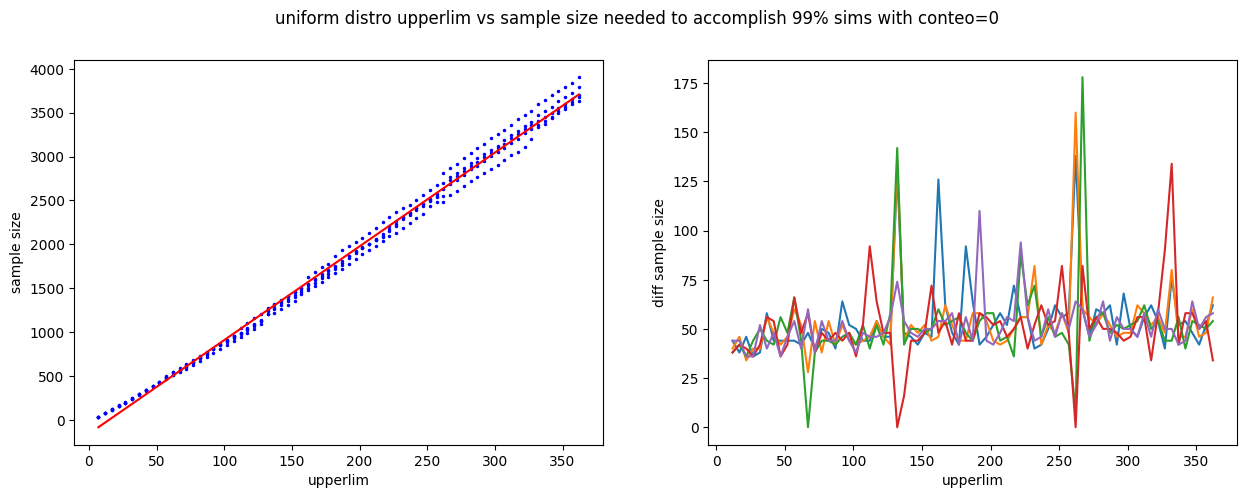

    UpperLimit  SampleSize0     Freq0  SampleSize1  Freq1  SampleSize2  \
0          7.0         36.0  0.992993         36.0   0.99         36.0   
1         12.0         80.0  0.991992         76.0   0.99         74.0   
2         17.0        118.0  0.990991        122.0   0.99        116.0   
3         22.0        164.0  0.991992        156.0   0.99        152.0   
4         27.0        200.0  0.992993        196.0   0.99        196.0   
..         ...          ...       ...          ...    ...          ...   
67       342.0       3700.0  0.990991       3570.0   0.99       3496.0   
68       347.0       3748.0  0.990991       3630.0   0.99       3550.0   
69       352.0       3790.0  0.990991       3676.0   0.99       3602.0   
70       357.0       3842.0  0.990991       3724.0   0.99       3652.0   
71       362.0       3904.0  0.990991       3790.0   0.99       3706.0   

       Freq2  SampleSize3     Freq3  SampleSize4     Freq4  SampleSize5  \
0   0.995127         36.0  0.993144 

In [180]:
reg= model.predict(np.array(DF['UpperLimit']).reshape(-1, 1))

fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('uniform distro upperlim vs sample size needed to accomplish 99% sims with conteo=0')

dfmin=df_fin[['SampleSize0','SampleSize1', 'SampleSize2',  'SampleSize3',  'SampleSize4',  'SampleSize5']].min(axis=1)
dfmax=df_fin[['SampleSize0','SampleSize1', 'SampleSize2',  'SampleSize3',  'SampleSize4',  'SampleSize5']].max(axis=1)

for i in np.arange(len(seeds)):
    axes[0].plot(DF.UpperLimit, df_fin['SampleSize'+str(i)], 'b.', markersize=3)
    axes[1].plot(DF.UpperLimit[1:], np.diff(df_fin['SampleSize'+str(i)]), '-')

axes[0].plot(DF.UpperLimit, reg, 'r-')
axes[0].set_xlabel("upperlim")
axes[0].set_ylabel("sample size")

axes[1].set_xlabel("upperlim")
axes[1].set_ylabel("diff sample size")

plt.show()
print(df_fin)